## Load libraries

In [1]:
from google.colab import drive
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

import zipfile
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Variable configuration

In [2]:
# Directory Paths
BASE_DIR = '/content/drive/MyDrive/DATASETS_EXP'

# Primary Dataset Paths
BASE_DATA_DIR = os.path.join(BASE_DIR, 'Data')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'Models')
PASTE_IMAGES_DIR = os.path.join(BASE_DIR, 'Augments')

DATASET_DIR = os.path.join(BASE_DATA_DIR, "PKLot_small")

TRAIN_DIR = os.path.join("/content/PKLot_small", 'Train')
TEST_DIR = os.path.join("/content/PKLot_small", 'Test')

GENERALIZATION_DIR = os.path.join("/content/CNRPark-EXT", 'Test')


# Paths for Copy-Paste Augmentation Images
TREE_DIRECTORY = os.path.join(PASTE_IMAGES_DIR, 'Tree')
POLE_DIRECTORY = os.path.join(PASTE_IMAGES_DIR, 'LightPole')

# Parameters
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.15
SEED = 123

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Declaration of functions

## Plotting

In [3]:
def plot_misclassified_images(model, dataset, class_names, num_images=5):
    misclassified_images = []
    predicted_labels = []
    true_labels = []

    for image_batch, label_batch in dataset:
        if len(misclassified_images) >= num_images:
            break

        preds_prob = model.predict(image_batch, verbose=0)
        preds_batch = (preds_prob > 0.5).astype("int32").flatten()

        labels_np = label_batch.numpy().astype("int32").flatten()

        mismatch_indices = np.where(preds_batch != labels_np)[0]

        for i in mismatch_indices:
            if len(misclassified_images) < num_images:
                image = image_batch[i].numpy()

                # MobileNetV3 preprocess_input scales to [-1, 1]
                # Convert back to [0, 1] for display
                if image.min() < 0:  # If values are in [-1, 1] range
                    image = (image + 1.0) / 2.0
                else:  # If values are in [0, 255] range
                    image = image / 255.0

                # Ensure values are within [0, 1] range
                image = np.clip(image, 0, 1)

                misclassified_images.append(image)
                predicted_labels.append(preds_batch[i])
                true_labels.append(labels_np[i])
            else:
                break

    if not misclassified_images:
        print("No misclassified images were found.")
        return

    plt.figure(figsize=(25, 10))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i + 1)

        image_to_plot = misclassified_images[i]

        plt.imshow(image_to_plot)
        pred_name = class_names[predicted_labels[i]]
        true_name = class_names[true_labels[i]]
        plt.title(f"Predicted: {pred_name}\nActual: {true_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Callback configuration



In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    min_delta=0.01,
)

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

CALLBACK_LIST = [early_stopping, lr_plateau]

## Model and Evaluation

In [5]:
def build_mobilenet_model(input_shape):
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def evaluate_model(model, test_dataset, general_dataset, class_names, num_missed_images=4):

    datasets_to_evaluate = [
        (test_dataset, "PKLot (Test)"),
        (general_dataset, "CNRPark-EXT (Generalization)")
    ]

    for dataset, name in datasets_to_evaluate:
        print(f"\n\n{'='*25}\n   EVALUATING ON: {name}\n{'='*25}")

        print(f"\nGenerating predictions for {name}...")
        y_pred_prob = model.predict(dataset, verbose=1)

        print("Extracting true labels...")
        y_true = np.concatenate([y for x, y in dataset], axis=0)

        # Convert probabilities to class predictions
        y_pred = (y_pred_prob > 0.5).astype(int)
        if y_pred.ndim > 1 and y_pred.shape[1] == 1:
            y_pred = y_pred.flatten()

        print(f"\nClassification Report ({name}):")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

        print(f"\nConfusion Matrix ({name}):")
        print(confusion_matrix(y_true, y_pred))

        print(f"\nDisplaying Misclassified Images ({name})")
        plot_misclassified_images(model, dataset, class_names, num_missed_images)


def run_experiment(experiment_name, train_data_config, model_builder_fn,
                   train_dir, test_dir, gen_dir,
                   img_shape, img_size, batch_size, epochs, val_split, callback_list):

    print(f"\n{'='*20} STARTING EXPERIMENT: {experiment_name.upper()} {'='*20}")

    print("\nLoading Datasets")
    train_ds, val_ds, test_ds, general_ds, class_names = load_datasets(
        train_dir, test_dir, gen_dir, img_size, batch_size, val_split
    )

    print("\nConfiguring Data Pipelines")
    train_ds = configure_dataset(train_ds, **train_data_config)
    val_ds = configure_dataset(val_ds)
    test_ds = configure_dataset(test_ds)
    general_ds = configure_dataset(general_ds)
    print(f"Training data configured with: {train_data_config}")

    model = model_builder_fn(img_shape)
    print("\nModel builded")

    print(f"\nStarting Training for {experiment_name}")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callback_list
    )

    plot_training_history(history)

    print(f"\nEvaluating model...")
    evaluate_model(model, test_ds, general_ds, class_names)

    print(f"\n{'='*20} FINISHED EXPERIMENT: {experiment_name.upper()} {'='*20}")

    return model, history

## Data augmentation

In [6]:
def _apply_paste(image_array, paste_images_list, flip_h=False, flip_v=False, rotate=False):
    base_image = tf.keras.preprocessing.image.array_to_img(image_array)

    if paste_images_list:
        paste_obj_pil = paste_images_list[np.random.randint(0, len(paste_images_list))]

        if flip_h:
            paste_obj_pil = paste_obj_pil.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        if flip_v:
            paste_obj_pil = paste_obj_pil.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        if rotate:
            paste_obj_pil = paste_obj_pil.rotate(np.random.randint(-45, 45))

        base_w, base_h = base_image.size
        paste_w, paste_h = paste_obj_pil.size

        offset_x = (base_w - paste_w) // 2
        offset_y = (base_h - paste_h) // 2

        base_image.paste(paste_obj_pil, (offset_x, offset_y), paste_obj_pil)

    return tf.keras.preprocessing.image.img_to_array(base_image)


def copy_paste_augmentation(image, label, tree_chance=0.1, lightpole_chance=0.03):

    def rnd():
        return np.random.choice([True, False])

    def augment(image):
        if np.random.rand() < tree_chance:
            image = _apply_paste(image, TREE_IMAGES, flip_h=rnd())

        if np.random.rand() < lightpole_chance:
            image = _apply_paste(image, LIGHT_POLE_IMAGES, flip_h=rnd())

        return image

    aug_image, = tf.py_function(augment, [image], [tf.float32])
    aug_image.set_shape(IMG_SHAPE)
    return aug_image, label

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])



## Dataset preparation

In [7]:
def load_datasets(train_dir, test_dir, generalization_dir, img_size, batch_size, val_split):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=val_split,
        subset="training",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=True
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=val_split,
        subset="validation",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=False
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=False
    )

    generalization_dataset = tf.keras.utils.image_dataset_from_directory(
        generalization_dir,
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=False
    )

    class_names = train_dataset.class_names
    print(f"Class names found: {class_names}")

    return train_dataset, val_dataset, test_dataset, generalization_dataset, class_names


def configure_dataset(dataset, copy_paste=False, data_augment=False, tree_chance=0.1, lightpole_chance=0.03):
    if copy_paste:
        def augment_batch(images, labels):
            aug_images = tf.map_fn(
                lambda img: copy_paste_augmentation(img, None, tree_chance, lightpole_chance)[0],
                images,
                dtype=tf.float32
            )
            return aug_images, labels
        dataset = dataset.map(augment_batch, num_parallel_calls=tf.data.AUTOTUNE)

    if data_augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Utils

In [8]:
def unzip_file(zip_file_path, destination_path):
    os.makedirs(destination_path, exist_ok=True)
    print(f"Extracting '{os.path.basename(zip_file_path)}' to '{destination_path}'...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)
    print("Extraction complete.")

def _load_images_from_dir(dir_path):
    images = []
    if not os.path.exists(dir_path):
        print(f"Warning: Directory not found at '{dir_path}'")
        return images

    for filename in sorted(os.listdir(dir_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(dir_path, filename)
                img = Image.open(img_path).convert("RGBA")
                images.append(img)
            except Exception as e:
                print(f"Could not load image {filename}: {e}")

    return images

def load_augment_images(tree_dir, pole_dir):
    tree_images = _load_images_from_dir(tree_dir)
    print(f"Loaded {len(tree_images)} images from '{tree_dir}'.")

    light_pole_images = _load_images_from_dir(pole_dir)
    print(f"Loaded {len(light_pole_images)} images from '{pole_dir}'.")

    return tree_images, light_pole_images

# Load Augmentation Images
try:
    TREE_IMAGES, LIGHT_POLE_IMAGES = load_augment_images(TREE_DIRECTORY, POLE_DIRECTORY)
except FileNotFoundError:
    print("Warning: Augmentation directories not found. Skipping image loading.")

Loaded 8 images from '/content/drive/MyDrive/DATASETS_EXP/Augments/Tree'.
Loaded 3 images from '/content/drive/MyDrive/DATASETS_EXP/Augments/LightPole'.


# Unzip CNRPark-EXT

In [9]:
unzip_file(os.path.join(BASE_DATA_DIR, 'CNRPark-EXT.zip'), '/content/')

Extracting 'CNRPark-EXT.zip' to '/content/'...
Extraction complete.


# Unzip PKLot

In [10]:
unzip_file(os.path.join(BASE_DATA_DIR, 'PKLot_small.zip'), '/content/')

Extracting 'PKLot_small.zip' to '/content/'...
Extraction complete.


# Test Copy Paste

Using sample image: /content/PKLot_small/Train/Empty/2013-03-10_13_15_08#034.jpg


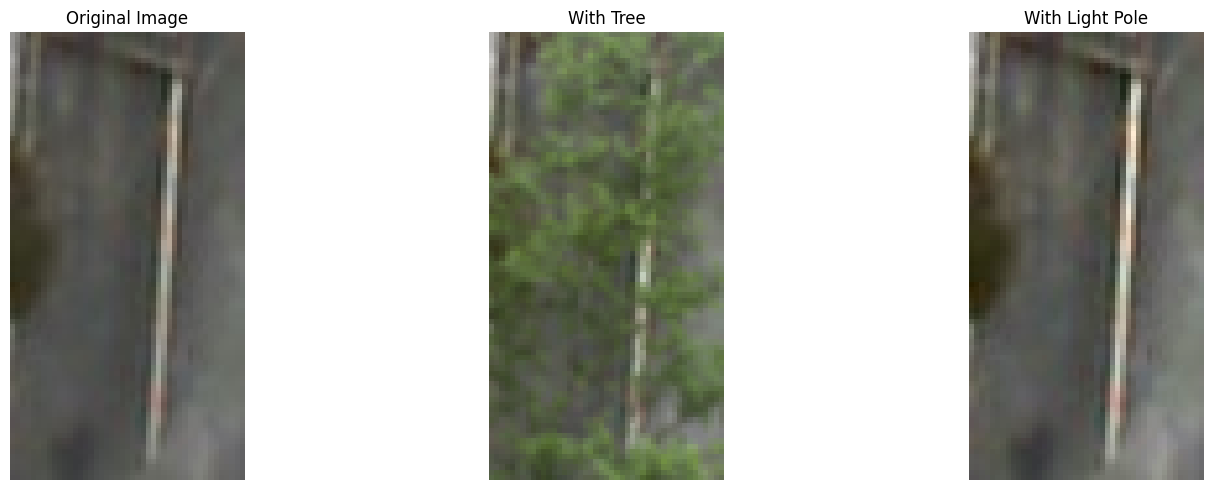

In [15]:
try:
    # Find the first class sub-directory in the training path (e.g., 'Occupied')
    class_folders = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    if not class_folders:
        raise FileNotFoundError(f"No class subdirectories found in '{TRAIN_DIR}'")

    first_class_folder = class_folders[1]
    class_path = os.path.join(TRAIN_DIR, first_class_folder)

    # Find the first image in that sub-directory
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        raise FileNotFoundError(f"No images found in '{class_path}'")

    sample_image_path = os.path.join(class_path, image_files[0])
    print(f"Using sample image: {sample_image_path}")

    # Load the original image using PIL and convert to a NumPy array
    original_image = Image.open(sample_image_path)
    original_image_array = np.array(original_image)

    # Apply each copy-paste augmentation individually to the original image
    tree_pasted_image = _apply_paste(original_image_array, TREE_IMAGES, flip_h=True)
    pole_pasted_image = _apply_paste(original_image_array, LIGHT_POLE_IMAGES, flip_h=True)

    # Convert the processed images back to a displayable format (uint8)
    images_to_plot = {
        "Original Image": original_image_array,
        "With Tree": np.clip(tree_pasted_image, 0, 255).astype(np.uint8),
        "With Light Pole": np.clip(pole_pasted_image, 0, 255).astype(np.uint8),
    }

    # Plot all four images for comparison
    plt.figure(figsize=(20, 5))
    for i, (title, img) in enumerate(images_to_plot.items()):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except (FileNotFoundError, IndexError) as e:
    print(f"Error finding a sample image: {e}")
except NameError as e:
    print(f"An error occurred, check if augmentation images (TREE_IMAGES, etc.) were loaded correctly: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Experiments

## Train

In [ ]:
baseline_configuration = {
    'data_augment': False,
    'copy_paste': False,
    'tree_chance': 0,
    'lightpole_chance': 0,
}

copypaste_configuration = {
    'data_augment': False,
    'copy_paste': True,
    'tree_chance': 0.1,
    'lightpole_chance': 0.03,
}


==================== STARTING EXPERIMENT: PK_COPYPASTE ====================

Loading Datasets
Found 19581 files belonging to 2 classes.
Using 16644 files for training.
Found 19581 files belonging to 2 classes.
Using 2937 files for validation.
Found 15209 files belonging to 2 classes.
Found 31825 files belonging to 2 classes.


Instructions for updating:
Use fn_output_signature instead


Class names found: ['Empty', 'Occupied']

Configuring Data Pipelines
Training data configured with: {'data_augment': False, 'copy_paste': True, 'tree_chance': 0.1, 'lightpole_chance': 0.03}

Model builded

Starting Training for pk_copypaste
Epoch 1/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.9069 - loss: 0.2525 - val_accuracy: 0.9990 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 2/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.9884 - loss: 0.0440 - val_accuracy: 0.9983 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 3/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.9923 - loss: 0.0285 - val_accuracy: 0.9983 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 4/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - accuracy: 0.9942 - loss: 0.0229 - val_accuracy: 0.9986 - val_loss: 0.0092 - learning_rate: 0.0010


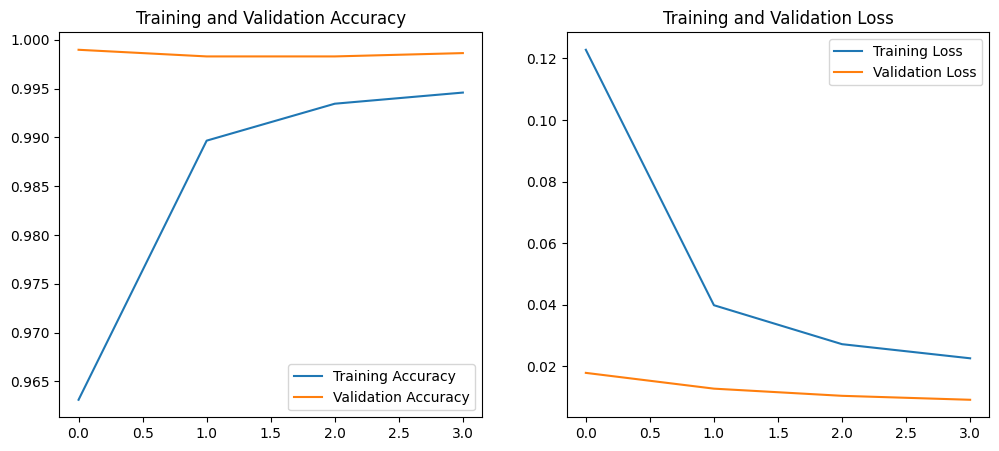


Evaluating model...


   EVALUATING ON: PKLot (Test)

Generating predictions for PKLot (Test)...
476/476 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step
Extracting true labels...

Classification Report (PKLot (Test)):
              precision    recall  f1-score   support

       Empty     0.9983    0.9851    0.9917      8459
    Occupied     0.9816    0.9979    0.9897      6750

    accuracy                         0.9908     15209
   macro avg     0.9900    0.9915    0.9907     15209
weighted avg     0.9909    0.9908    0.9908     15209


Confusion Matrix (PKLot (Test)):
[[8333  126]
 [  14 6736]]

Displaying Misclassified Images (PKLot (Test))


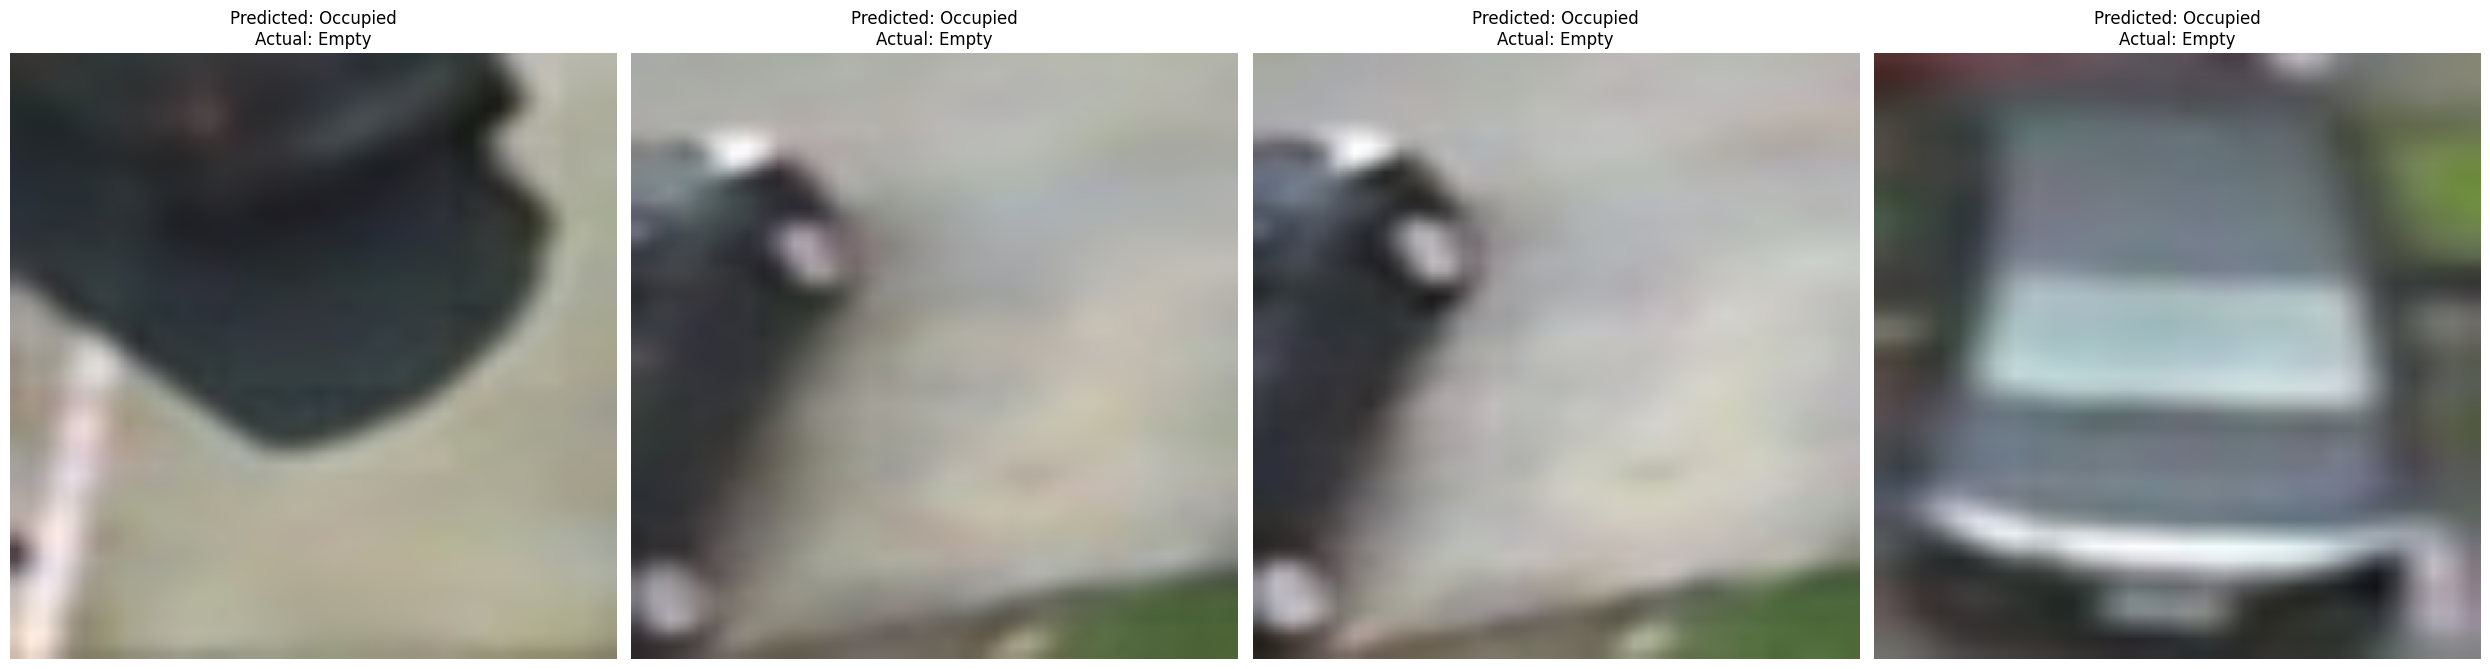



   EVALUATING ON: CNRPark-EXT (Generalization)

Generating predictions for CNRPark-EXT (Generalization)...
995/995 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step
Extracting true labels...

Classification Report (CNRPark-EXT (Generalization)):
              precision    recall  f1-score   support

       Empty     0.9485    0.9658    0.9571     13549
    Occupied     0.9743    0.9611    0.9677     18276

    accuracy                         0.9631     31825
   macro avg     0.9614    0.9635    0.9624     31825
weighted avg     0.9633    0.9631    0.9632     31825


Confusion Matrix (CNRPark-EXT (Generalization)):
[[13086   463]
 [  711 17565]]

Displaying Misclassified Images (CNRPark-EXT (Generalization))


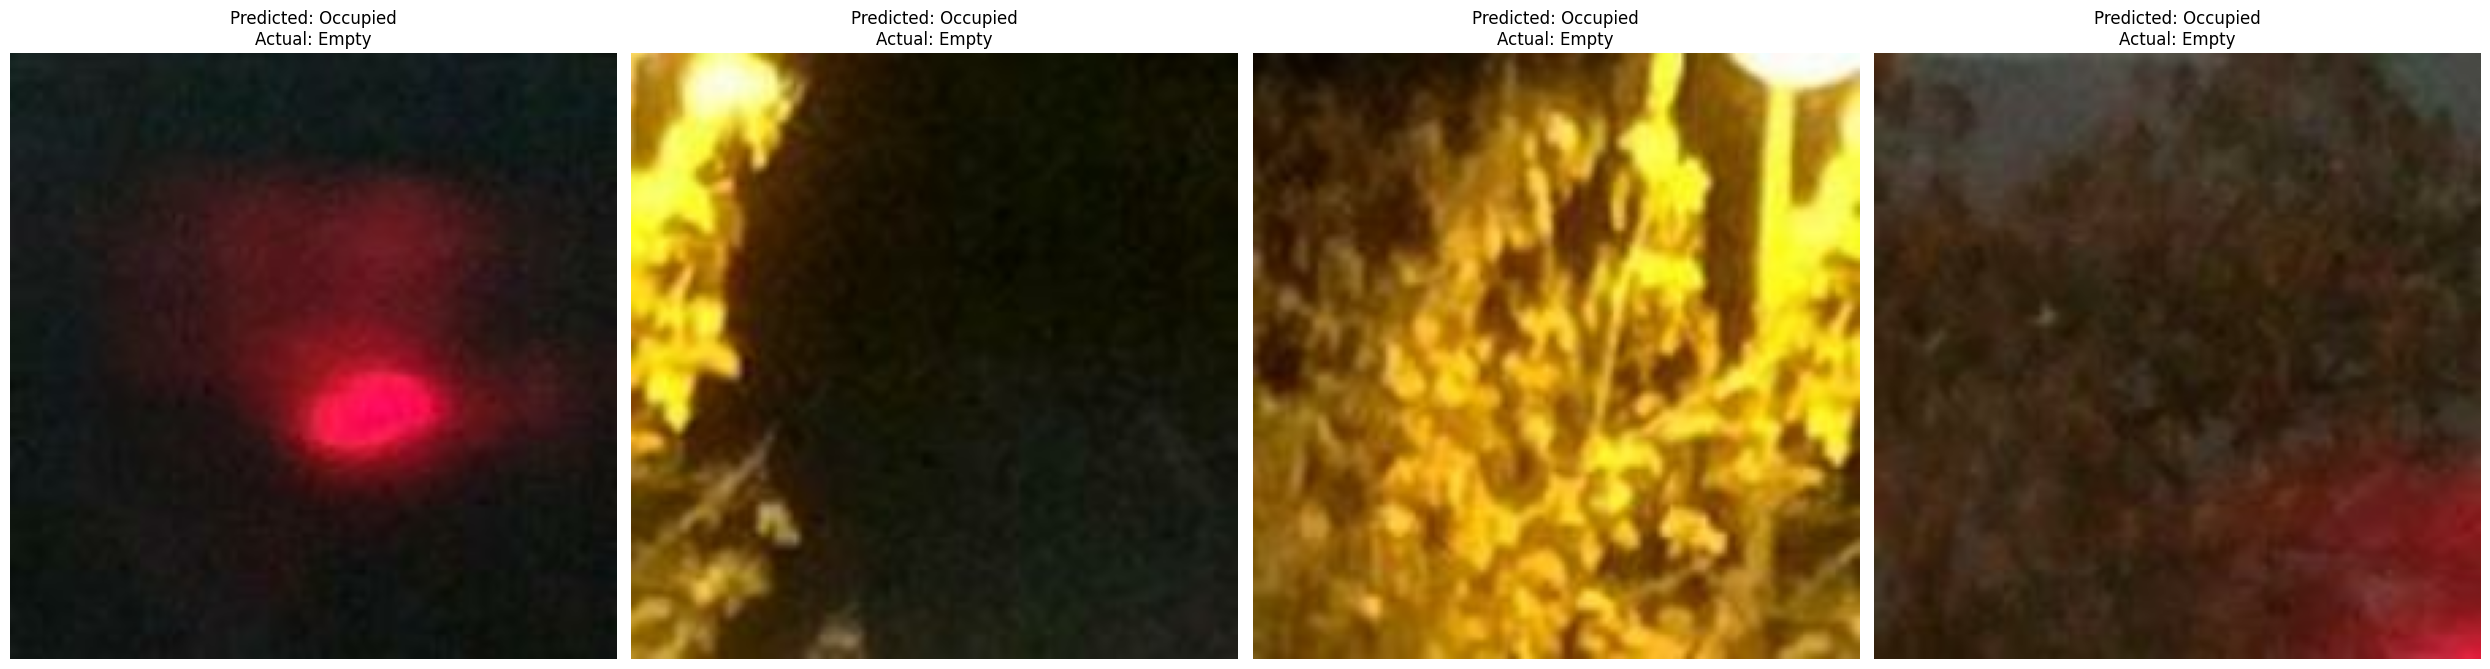


==================== FINISHED EXPERIMENT: PK_COPYPASTE ====================


In [ ]:
model, history = run_experiment(
        "pk_copypaste",
        copypaste_configuration,
        build_mobilenet_model,
        TRAIN_DIR,
        TEST_DIR,
        GENERALIZATION_DIR,
        IMG_SHAPE,
        IMG_SIZE,
        BATCH_SIZE,
        EPOCHS,
        VALIDATION_SPLIT,
        CALLBACK_LIST
)

In [ ]:
model = build_mobilenet_model(IMG_SHAPE)

## Save weights

In [ ]:
# model_name = "pk_copypaste"
# weights_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}.weights.h5')
# os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
# model.save_weights(weights_filepath)
# print(f"Weights saved at: {weights_filepath}")

Weights saved at: /content/drive/MyDrive/DATASETS_EXP/Models/pk_copypaste.weights.h5


## Load weights

In [ ]:
model_name = "pk_copypaste"
weights_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}.weights.h5')
print(f"Loading weights from: {weights_filepath}...")
model.load_weights(weights_filepath)
print(f"{model_name} loaded into the new model.")

Loading weights from: /content/drive/MyDrive/DATASETS_EXP/Models/pk_copypaste.weights.h5...
pk_copypaste loaded into the new model.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Tests

In [ ]:
TEST_DIR = "/content/drive/MyDrive/DATASETS_EXP/Data/Tests"
DATASET_NAME = "PKLot"
TYPE = "CopyPaste"

In [ ]:
#TEST_DIRS_PKLOT = ["UFPR05", "UFPR04", "PUC"]
TEST_DIRS_PKLOT = ["UFPR05", "UFPR04", "PUC"]
TEST_DIRS_CNR = ["CAMERA1", "CAMERA2", "CAMERA3", "CAMERA4", "CAMERA5", "CAMERA6", "CAMERA7", "CAMERA8", "CAMERA9", "CNRPARK-TEST"]

In [ ]:
SAVE_DIR = f"/content/drive/MyDrive/DATASETS_EXP/Results/{DATASET_NAME}/{TYPE}"

In [ ]:
print("Saving contents to directory:", SAVE_DIR)

for dir in TEST_DIRS_PKLOT:

    unzip_file(os.path.join(TEST_DIR, f'{dir}.zip'), '/content/')

    file_name = f"{model_name}_{dir}.txt"

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        f"/content/{dir}/Test",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary',
        shuffle=False
    )

    y_pred_prob = model.predict(test_dataset, verbose=1)

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)

    y_pred = (y_pred_prob > 0.5).astype(int)
    if y_pred.ndim > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()

    with open(f"{SAVE_DIR}/{file_name}", 'w') as f:
        # Get the report string and confusion matrix array
        report = classification_report(y_true, y_pred, target_names=test_dataset.class_names, digits=4)
        cm = confusion_matrix(y_true, y_pred)

        # Print the report header and content to the file
        print("--- Classification Report ---", file=f)
        print(report, file=f)

        # Print a separator and the confusion matrix to the same file
        print("\n--- Confusion Matrix ---", file=f)
        print(cm, file=f)

Saving contents to directory: /content/drive/MyDrive/DATASETS_EXP/Results/PKLot/CopyPaste
Extracting 'UFPR05.zip' to '/content/'...
Extraction complete.
Found 165785 files belonging to 2 classes.
5181/5181 ━━━━━━━━━━━━━━━━━━━━ 136s 26ms/step
Extracting 'UFPR04.zip' to '/content/'...
Extraction complete.
Found 105843 files belonging to 2 classes.
3308/3308 ━━━━━━━━━━━━━━━━━━━━ 87s 26ms/step
Extracting 'PUC.zip' to '/content/'...
Extraction complete.
Found 632610 files belonging to 2 classes.
19770/19770 ━━━━━━━━━━━━━━━━━━━━ 547s 28ms/step
